### Calculating speed of sound from 2022 Tonga eruption shockwaves in the US
(code was written without LLMs)

In [22]:
# %init
import json, glob, sys, os, gzip, time
from IPython.display import HTML
import ipywidgets
import numpy as np ; np.set_printoptions(linewidth=150)
import pandas as pd
import matplotlib.pyplot as plt
from yahist import set_default_style, Hist1D, Hist2D
from tqdm.auto import tqdm
import requests
        
from scipy.signal import find_peaks

In [2]:
states = """AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME
 MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT
 WA WI WV WY""".split()

# tonga_lat, tonga_lon = -20.5806403,-175.4002756
tonga_lat, tonga_lon = -20.5455155,-175.3920198
def calc_dist_km(lat1, lon1, lat2=tonga_lat, lon2=tonga_lon):
    R = 6371e3 # meters
    phi1 = lat1 * np.pi/180
    phi2 = lat2 * np.pi/180
    dphi = (lat2-lat1) * np.pi/180
    dlam = (lon2-lon1) * np.pi/180
    a = np.sin(dphi/2) * np.sin(dphi/2) + np.cos(phi1) * np.cos(phi2) * np.sin(dlam/2) * np.sin(dlam/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R*c
    return d/1e3

# calc_dist_km(df["lat"], df["lon"], tonga_lat, tonga_lon)

In [3]:
!mkdir -p data/

def get_states():
    # IEM quirk to have Iowa AWOS sites in its own labeled network
    for state in states:
        print(state)
        r = requests.get(f"https://mesonet.agron.iastate.edu/geojson/network/{state}_ASOS.geojson")
        stations = [site["properties"]["sid"] for site in r.json()["features"]]
        
        url = "https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?data=alti&data=tmpc&data=mslp&year1=2022&month1=1&day1=14&year2=2022&month2=1&day2=17&tz=Etc%2FUTC&format=onlycomma&latlon=yes&elev=yes&missing=M&trace=T&direct=no&report_type=1&report_type=2"
        for station in stations:
            url += f"&station={station}"
        r = requests.get(url)
        
        with open(f"data/{state}_2022-01-14.csv", "wb") as fh:
            fh.write(r.content)


# get_states()

In [5]:
if not os.path.exists("dfc.parquet"):
    dfs = []
    for state in tqdm(states):
        df = pd.read_csv(f"data/{state}_2022-01-14.csv")
        df["valid"] = pd.to_datetime(df["valid"])
        df["station"] = df["station"].astype("category")
        df["alti"] = pd.to_numeric(df["alti"], errors="coerce")
        df = df.dropna().reset_index(drop=True)
        df["state"] = state
        df["state"] = df["state"].astype("category")
        dfs.append(df)
    dfc = pd.concat(dfs)
    del dfs
    dfc.to_parquet("dfc.parquet")
    !ls -lrth dfc.parquet
else:
    dfc = pd.read_parquet("dfc.parquet")

In [6]:
dfc = dfc[dfc.eval("(-150 < lon < -50) and (lat < 50)")].reset_index(drop=True)
avg_over = "1h"
# dfc = dfc.merge(dfc.groupby("station")["alti"].median().to_frame("alti_avg"), on="station")
dfc[f"time_{avg_over}"] = dfc["valid"].dt.floor(f"{avg_over}")
dfc = dfc.merge(
    dfc.groupby(["station",f"time_{avg_over}"])["alti"].median().to_frame("alti_avg").reset_index(),
    on=["station",f"time_{avg_over}"]
)
dfc["alti_delta"] = dfc["alti"]-dfc["alti_avg"]
dfc["time_15min"] = dfc["valid"].dt.floor("15min")
dfc["time_2min"] = dfc["valid"].dt.round("2min")
dfc["dist_km"] = calc_dist_km(dfc["lat"],dfc["lon"])
dfc

,station,valid,lon,lat,elevation,alti,tmpc,mslp,state,time_1h,alti_avg,alti_delta,time_15min,time_2min,dist_km
0,HSV,2022-01-14 00:00:00,-86.7861,34.6439,196.00,29.94,M,M,AL,2022-01-14 00:00:00,29.94,0.0,2022-01-14 00:00:00,2022-01-14 00:00:00,11165.560061
1,HSV,2022-01-14 00:05:00,-86.7861,34.6439,196.00,29.94,M,M,AL,2022-01-14 00:00:00,29.94,0.0,2022-01-14 00:00:00,2022-01-14 00:04:00,11165.560061
2,HSV,2022-01-14 00:10:00,-86.7861,34.6439,196.00,29.94,M,M,AL,2022-01-14 00:00:00,29.94,0.0,2022-01-14 00:00:00,2022-01-14 00:10:00,11165.560061
3,HSV,2022-01-14 00:15:00,-86.7861,34.6439,196.00,29.94,M,M,AL,2022-01-14 00:00:00,29.94,0.0,2022-01-14 00:15:00,2022-01-14 00:16:00,11165.560061
4,HSV,2022-01-14 00:20:00,-86.7861,34.6439,196.00,29.94,M,M,AL,2022-01-14 00:00:00,29.94,0.0,2022-01-14 00:15:00,2022-01-14 00:20:00,11165.560061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070076,BYG,2022-01-16 23:50:00,-106.7200,44.3800,1514.00,30.02,M,M,WY,2022-01-16 23:00:00,30.02,0.0,2022-01-16 23:45:00,2022-01-16 23:50:00,10020.588580
1070077,BYG,2022-01-16 23:53:00,-106.7200,44.3800,1514.00,30.02,1.72,1017.90,WY,2022-01-16 23:00:00,30.02,0.0,2022-01-16 23:45:00,2022-01-16 23:52:00,10020.588580
1070078,BYG,2022-01-16 23:55:00,-106.7200,44.3800,1514.00,30.02,M,M,WY,2022-01-16 23:00:00,30.02,0.0,2022-01-16 23:45:00,2022-01-16 23:56:00,10020.588580
1070079,FEW,2022-01-16 23:58:00,-104.8672,41.1333,1878.00,30.07,0.61,1019.90,WY,2022-01-16 23:00:00,30.07,0.0,2022-01-16 23:45:00,2022-01-16 23:58:00,9980.295026


  0%|          | 0/142 [00:00<?, ?it/s]

60

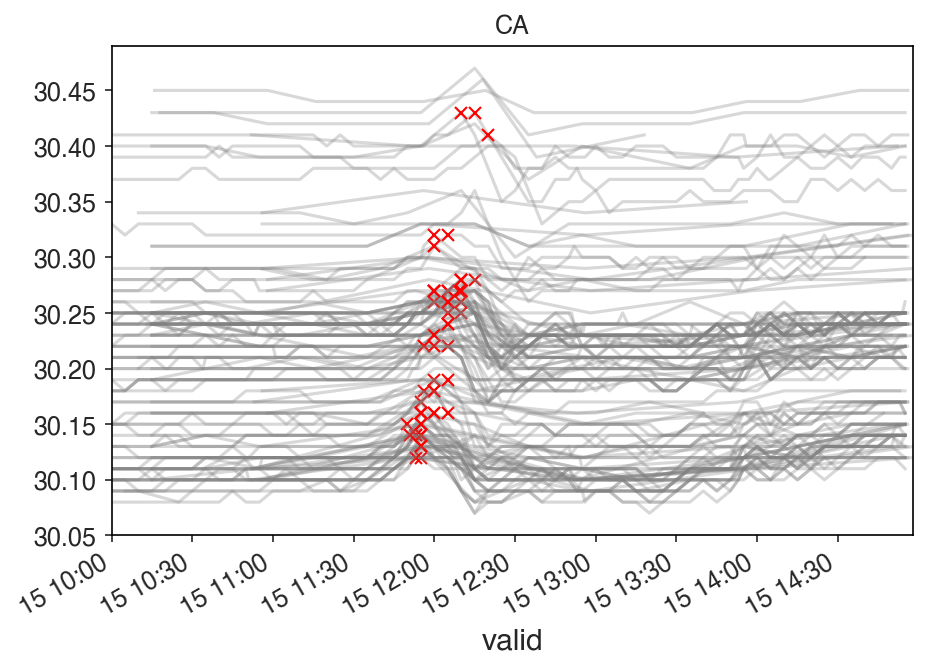

In [7]:
fig, ax = plt.subplots()
# fig, ax = plt.subplots(figsize=(18,4))
# state = "CO"
# state = "TX"
state = "CA"
df = dfc[dfc["state"]==state]
largest = df["station"].value_counts().nlargest(60)
npeaks = 0
for i, (station, group) in enumerate(tqdm(df.set_index("valid").groupby("station"))):
#     if station not in largest.index: continue
#     print(i, group.index.min(), group.index.max(), len(group))
#     if i > 10: break
    s = group["alti"].loc["2022-01-15 10am":"2022-01-15 2pm"]
#     s = group["alti"].loc["2022-01-16 12pm":"2022-01-16 8pm"]

    s.plot(color="gray", alpha=0.3)
    
#     if i>10:
#         break
    
    peaks = find_peaks(s, prominence=0.03, width=2)
#     peaks = find_peaks(s, prominence=0.04, width=2)
    idxs = peaks[0]
    if len(idxs):
        for idx in idxs:
            npeaks += 1
            x = s.index[idx]
            y = s.values[idx]
            ax.plot(x,y, color="red", marker="x")
ax.set_title(state)
npeaks

  0%|          | 0/2242 [00:00<?, ?it/s]

545

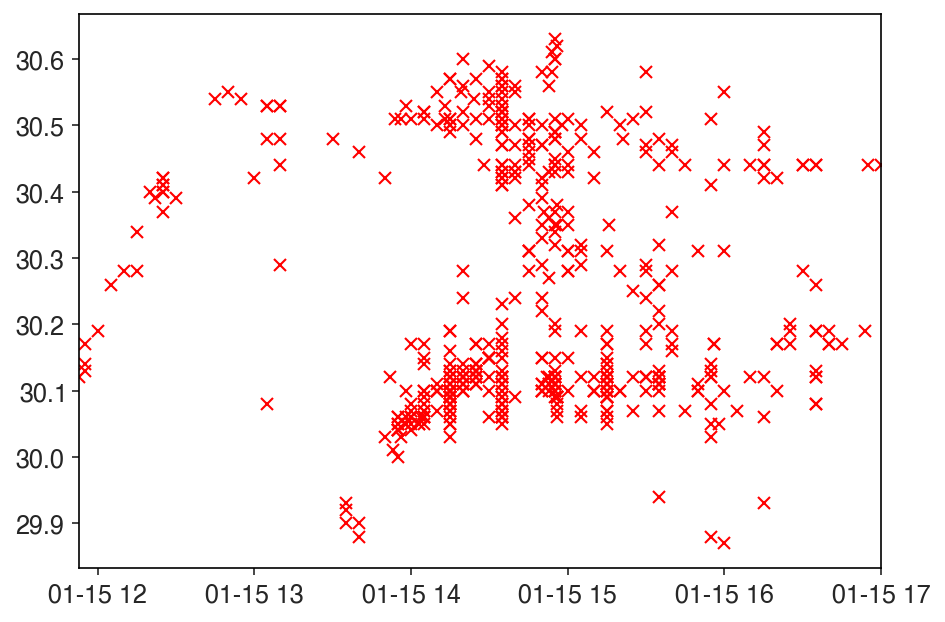

In [8]:
fig, ax = plt.subplots()
df = dfc
npeaks = 0
all_peaks = {}
for i, (station, group) in enumerate(tqdm(df.set_index("valid").groupby("station"))):
    s = group["alti"].loc["2022-01-15 10am":"2022-01-15 5pm"]
#     s = group["alti"].loc["2022-01-16 1pm":"2022-01-16 8pm"]
    peaks = find_peaks(s, prominence=0.04, width=3)
    idxs = peaks[0]
    if len(idxs):
#     if len(idxs) == 1:
        for idx in idxs:
            npeaks += 1
            x = s.index[idx]
            y = s.values[idx]
            ax.plot(x,y, color="red", marker="x")
            all_peaks[station] = x
#             break
npeaks

In [9]:
# all_peaks
df = dfc.drop_duplicates("station")[["station","lon","lat","state","dist_km"]].merge(
    pd.DataFrame(all_peaks.items(), columns=["station","tpeak"]),
    on="station",
)
df

,station,lon,lat,state,dist_km,tpeak
0,HSV,-86.7861,34.6439,AL,11165.560061,2022-01-15 14:35:00
1,EET,-86.7800,33.1800,AL,11115.829576,2022-01-15 14:00:00
2,TOI,-86.0121,31.8604,AL,11138.872986,2022-01-15 14:05:00
3,GAD,-86.0891,33.9727,AL,11203.791670,2022-01-15 14:05:00
4,AUO,-85.4340,32.6151,AL,11216.239307,2022-01-15 14:05:00
...,...,...,...,...,...,...
419,BKW,-81.1242,37.7873,WV,11750.062408,2022-01-15 14:50:00
420,EKN,-79.8528,38.8853,WV,11886.538689,2022-01-15 14:55:00
421,I16,-81.5600,37.6000,WV,11707.770243,2022-01-15 14:50:00
422,6L4,-81.9159,37.8557,WV,11684.564048,2022-01-15 14:35:00


(<matplotlib.image.AxesImage at 0x16e11f340>,
 <AxesSubplot: xlabel='tpeak', ylabel='dist_km'>)

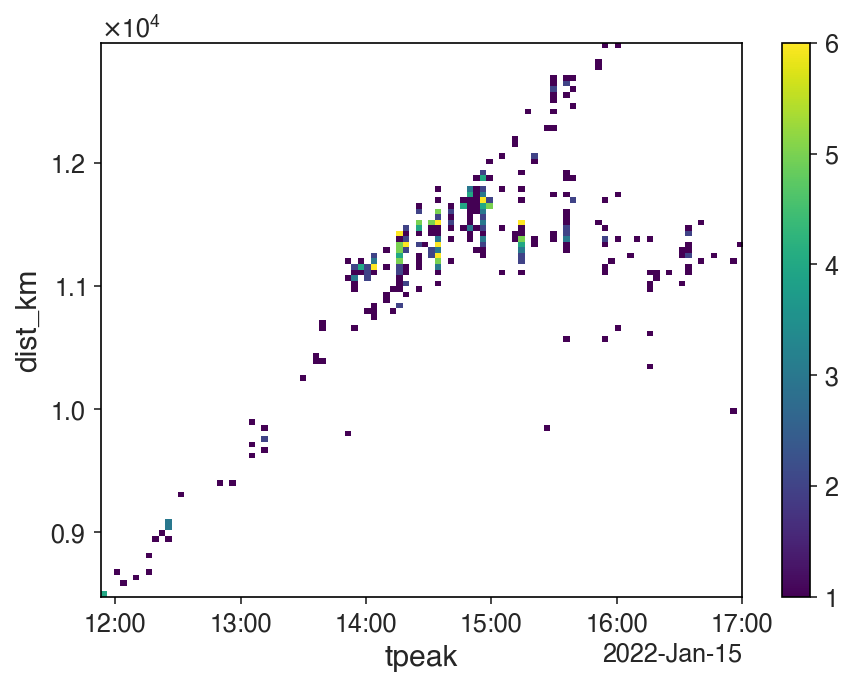

In [10]:
h = Hist2D(df[["tpeak","dist_km"]], bins=100)
h.plot()

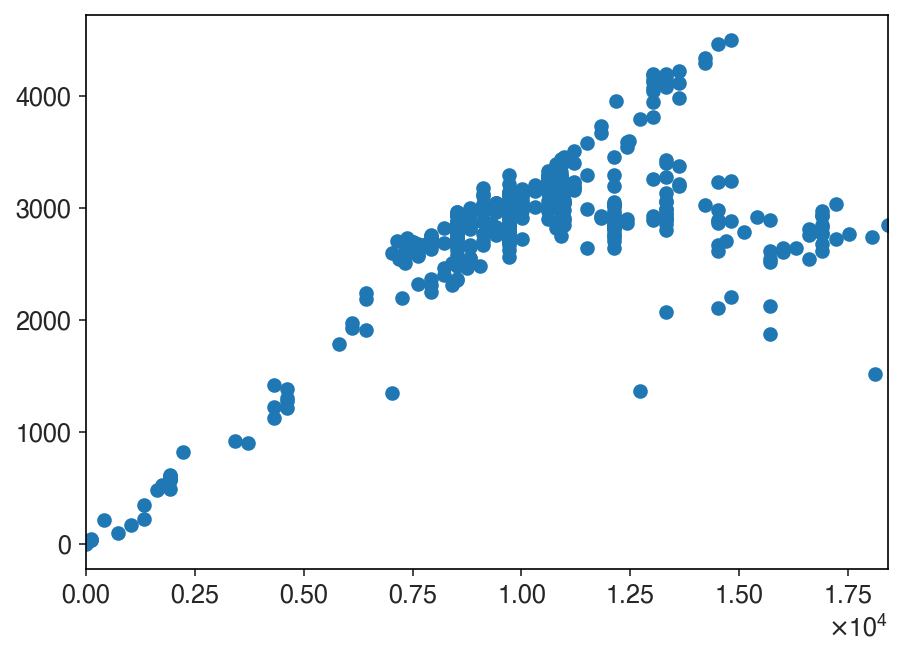

In [11]:
sec = (df["tpeak"]-df["tpeak"].min()).dt.total_seconds().values
km = (df["dist_km"]-df["dist_km"].min()).values
plt.scatter(sec, km)

/var/folders/q_/4xc9d8p90fx9q_nm27yc51bh0000gn/T/ipykernel_39120/2752298719.py:1: RuntimeWarning: invalid value encountered in divide
  v = 1000*km/sec


parameter,value
constant,24.24 ± 1.684
mean,306.4 ± 1.654
sigma,27.56 ± 1.319


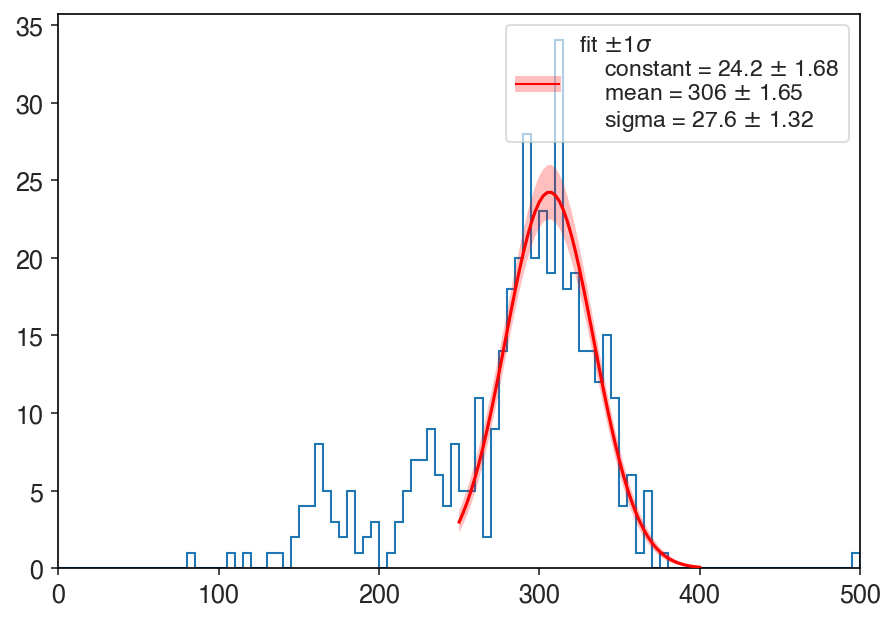

In [12]:
v = 1000*km/sec
v = v[np.isfinite(v)]
h = Hist1D(v, bins="100,0,500")
h.plot()
h.restrict(250,400).fit("gaus", likelihood=True)

### 306 m/s, not bad. Actually, found this paper in 2024 and they got 310 m/s: https://www.sciencedirect.com/science/article/pii/S2589004222016285#:~:text=The%20speed%20of%20shockwaves%20is,troposphere%20where%20a%20waveguide%20exists.

In [13]:
# Hist2D(dfc[["lat","lon"]].drop_duplicates(), bins=50).transpose().plot(interactive=True)

In [14]:
df = dfc.set_index("time_15min").groupby("station").resample("15min")["alti_delta"].mean().ffill().reset_index()
df = df.merge(dfc[["station","lat","lon"]].drop_duplicates(), on="station")

df = df[df["station"].isin(dfc["station"].value_counts().nlargest(700).index)]

df = df.set_index(["time_15min","station"]).sort_index()
df


alti_delta      lat       lon
time_15min          station                               
2022-01-14 00:00:00 1M4       -0.003333  34.2803  -87.6004
                    7N0        0.000000  29.9527  -90.0827
                    ABE        0.000000  40.6508  -75.4492
                    ABI        0.000000  32.4106  -99.6821
                    ABQ        0.006667  35.0419 -106.6155
...                                 ...      ...       ...
2022-01-16 23:45:00 YIP       -0.010000  42.2379  -83.5304
                    YKM       -0.007500  46.5682 -120.5441
                    YKN        0.005000  42.9167  -97.3859
                    YNG       -0.010000  41.2544  -80.6739
                    ZZV       -0.015000  39.9445  -81.8921

[201541 rows x 3 columns]

### Interactively scrub through the shockwave propagation across the US...

In [17]:
%%time
from ipywidgets import interact, IntSlider
dts = dfc["time_15min"].unique()
def plot(i):
    fig, ax = plt.subplots(figsize=(8,6))
    dt = dts[i]
    tmp = df.loc[dt]
    y = tmp["lat"]
    x = tmp["lon"]
    z = tmp["alti_delta"]
    im = ax.scatter(x, y, c=z, vmin=-0.1, vmax=0.1, cmap="bwr", s=20)
    fig.colorbar(im, ax=ax)
    ax.set_xlim([-124.5, -67.8])
    ax.set_ylim([24.5, 49.4])
    ax.set_title(str(dt).split(".")[0])
    
interactive_plot = interact(i=IntSlider(min=130, max=170, step=1, value=130))(plot)

interactive(children=(IntSlider(value=130, description='i', max=170, min=130), Output()), _dom_classes=('widge…

CPU times: user 768 ms, sys: 10.4 ms, total: 778 ms
Wall time: 285 ms


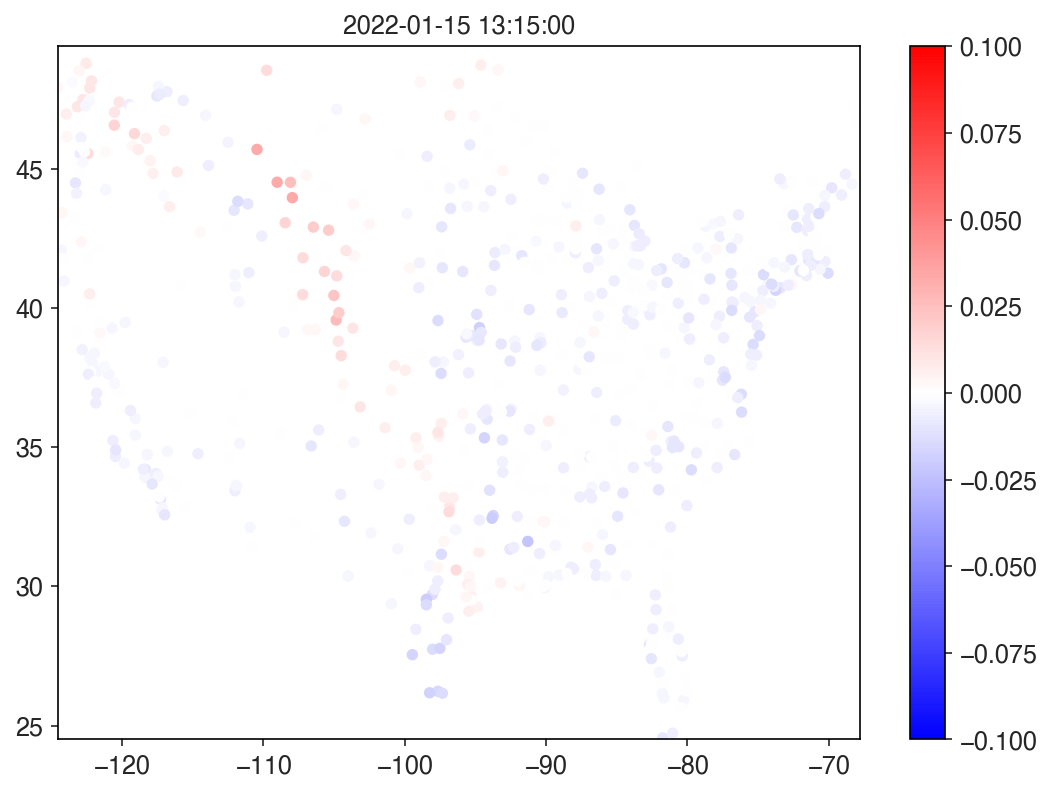

In [21]:
plot(149)